In [1]:
# lib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from scipy.special import expit
from keras.utils.np_utils import to_categorical
from random import seed


In [2]:
# Splitting into training, validation and test sets
seed(0)
((x_train, y_train), (x_test, y_test)) = tf.keras.datasets.mnist.load_data()
X = np.vstack((x_train, x_test))
y = np.hstack((y_train, y_test))

X = (X / 255) - 0.5
X = X.reshape((-1, 784))
# X = np.array(X, dtype = np.float128)
# y = np.array(y, dtype = np.float128)


11501568/11490434 [==============================] - 0s 0us/step


In [3]:

# Split
indices = list(range(X.shape[0]))
training_instances = int(0.7 * X.shape[0])
validation_instances = int(0.1 * X.shape[0])
np.random.shuffle(indices)
train = indices[:training_instances]
validation = indices[training_instances:training_instances + validation_instances + 1]
test = indices[training_instances + validation_instances + 1:]

y = to_categorical(y)

X_train, X_validation, X_test = X[train], X[validation], X[test]
y_train, y_validation, y_test = y[train], y[validation], y[test]


In [9]:
class MyNeuralNetwork():
    def __init__(self, N_layers, Layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        self._N_layers = N_layers
        self._Layer_sizes = Layer_sizes


        self._activation = activation
        self._learning_rate = learning_rate
        self._weight_init = weight_init
        self._batch_size = batch_size
        self._num_epochs = num_epochs
        self._params = {}
        self.initialization()

        self._params["bias"] = np.zeros((self._N_layers - 1,))


    def zero_initialization(self, w_rows, w_cols):
        return np.zeros((w_rows, w_cols))

    def random_initialization(self, w_rows, w_cols, alpha = 0.01):
        return np.random.randn(w_rows, w_cols) * alpha


    def normal_initialization(self, w_rows, w_cols, alpha = 0.01, mean = 0, std = 1):
        return np.random.normal(mean, std, size = (w_rows, w_cols)) * alpha

    def relu(self, X):
        return X * (X > 0)
        
    def leakyrelu(self, X, a = 0.01):
        return np.maximum(a*X, X)

    def sigmoid(self, X):
        return (1/ 1 + np.exp(-X))

    def softmax(self, X):
        f = np.exp(X - np.max(X))  # shift values
        return f / f.sum(axis=0)
  
    def linear(self, X):
        return X

    def tanh(self, X):
        return np.tanh(X)

    # derivative of activation functions
    def reluPrime(self, X):
        return np.matmul(np.identity(X.shape[0]), (X > 0))

    def leakyreluPrime(self, X, alpha = 0.01):
        return np.clip(X, alpha, 1)

    def sigmoidPrime(self, X):
        return self.sigmoid(X)*(1-self.sigmoid(X))

    def softmaxPrime(self, X):
        exp_element = np.exp(X - X.max())
        return exp_element/np.sum(exp_element, axis = 0)*(1 - exp_element/np.sum(exp_element, axis = 0))


    def linearPrime(self, X):
        dx = np.ones_like(X)
        return dx

    def tanhPrime(self, X):
        return (1 - self.tanh(X)**2)

    # Activation functions
    def activation(self, X, alpha = 0.01, final_ = False):

        if (final_):
            return (self.softmax(X))

        if self._activation == "relu":
            return (self.relu(X))

        elif self._activation == "leaky relu":
            return (self.leakyrelu(X), alpha)

        elif self._activation == "sigmoid":
            return (self.sigmoid(X))
        
        elif self._activation == "softmax":
            return (self.softmax(X))

        elif self._activation == "linear":
            return (self.linear(X))
     
        else:
            return (self.tanh(X))
 

    
    def derivative(self, X, alpha = 0.01, final_ = False):

        if (final_):
            return (self.softmaxPrime(X))

        if self._activation == "relu":
            return (self.reluPrime(X))

        elif self._activation == "leaky relu":
            return (self.leakyreluPrime(X), alpha)

        elif self._activation == "sigmoid":
            return (self.sigmoidPrime(X))
        
        elif self._activation == "softmax":
            return (self.softmaxPrime(X))

        elif self._activation == "linear":
            return (self.linearPrime(X))
        
        elif self._activation == "tanh":
            return (self.tanhPrime(X))

        return self.relu(X)    

    # initilization
    def initialization(self):
        for i in range(1, self._N_layers):
            name = "W" + str(i)

            if (self._weight_init == "zero"):
                layer_weights = self.zero_initialization(self._Layer_sizes[i], self._Layer_sizes[i-1])
            
            elif (self._weight_init == "random"):
                layer_weights = self.random_initialization(self._Layer_sizes[i], self._Layer_sizes[i-1])
                
            else:
                layer_weights = self.normal_initialization(self._Layer_sizes[i], self._Layer_sizes[i-1])

            self._params[name] = layer_weights

    
    def forward(self, x):
        params = self._params

        params["Y0"] = x.T
        
        # w'x and g(w'x)
        for i in range(1, self._N_layers - 1):
            name1 = "V" + str(i)
            params[name1] = np.dot(params["W" + str(i)], params["Y" + str(i-1)]) + params["bias"][i - 1]
            name2 = "Y" + str(i)
            params[name2] = self.activation(params[name1])
            
        params["V" + str(self._N_layers - 1)] = np.dot(params["W" + str(self._N_layers - 1)], params["Y" + str(self._N_layers - 2)])
        params["Y" + str(self._N_layers - 1)] = self.activation(params["V" + str(self._N_layers - 1)], final_=True)
        
        return params["Y" + str(self._N_layers - 1)]
       

    def backward(self, y_train, output):
        
        params = self._params
        update_w = {}
        
        # error and derivative
        error = 2 * (output - y_train.T) * self.derivative(params['V' +  str(self._N_layers - 1)], final_ = True )
        update_w['W' + str(self._N_layers - 1)] = np.dot(error, params["Y" + str(self._N_layers - 2)].T)
        
        
        for i in range(self._N_layers - 2, 0, -1):

            error = np.dot(params['W' + str(i+1)].T, error) * self.derivative(params['V' + str(i)])
            update_w['W' + str(i)] = np.dot(error, params["Y" + str(i-1)].T)    
        
        return update_w

    def update_network_parameters(self, changes_to_w):
        
        for key, value in changes_to_w.items():
            self._params[key] -= self._learning_rate * value 
            

    def score(self, x_val, y_val):
        predictions = []

        output = self.forward(x_val)
        pred = np.argmax(output, axis = 0)
        y_val_new = np.argmax(y_val, axis = 1)
        
        # accuracy
        acc = 0
        for i in range(len(pred)):
            if (pred[i] == y_val_new[i]):
                acc += 1
        
        return acc/len(pred)

    def predict(self, x_val):
        output = self.forward(x_val)
        return np.argmax(output, axis = 0)
    
    def predict_proba(self, x_val):
        return self.forward(x_val)

    def fit(self, x_train, y_train, x_val, y_val):

        val_epoch = []
        train_epoch = []
        start_time = time.time()
        num_batches = int(np.ceil(np.divide(X_train.shape[0], self._batch_size)))

        for iteration in range(self._num_epochs):
            for b in range(num_batches):

                batch_inds = np.arange(b*self._batch_size, min((b+1)*self._batch_size, X_train.shape[0]))
                output = self.forward(X_train[batch_inds])
                changes_to_w = self.backward(y_train[batch_inds], output)
                self.update_network_parameters(changes_to_w)

            accuracy = self.score(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy *100
            ))

            val_epoch.append(accuracy)
            train_epoch.append(self.score(X_train, y_train))

        return val_epoch, train_epoch

        


In [ ]:
# activation function: sigmoid
myNet = MyNeuralNetwork(6, [784, 256, 128, 64, 32, 10], "sigmoid", 0.08, "normal", X_train.shape[0], 15)
validationLoss, trainLoss = myNet.fit(X_train, y_train, X_validation, y_validation)
y_pred = myNet.predict(X_test)




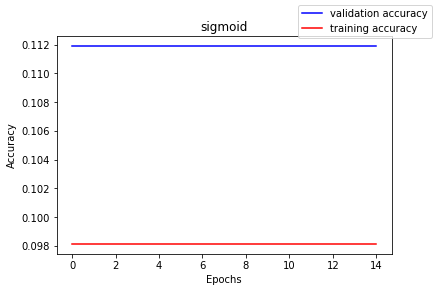

In [8]:
plt.plot(list(range(15)),validationLoss,  label = "validation accuracy", color = 'blue')
plt.plot(list(range(15)), trainLoss,  label = "training accuracy", color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("sigmoid")
plt.figlegend()
plt.show()


In [ ]:
# relu
myNet = MyNeuralNetwork(6, [784, 256, 128, 64, 32, 10], "relu", 0.08, "normal", X_train.shape[0], 10)
validationLoss, trainLoss = myNet.fit(X_train, y_train, X_validation, y_validation)
y_pred = myNet.predict(X_test)

print("The accuracy for test set", myNet.score(X_test, y_test) )



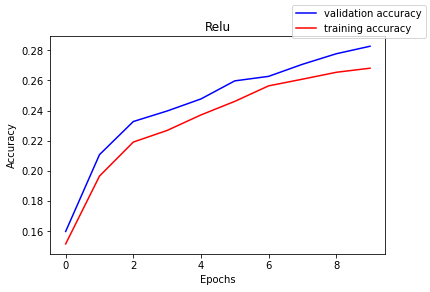

In [12]:
plt.plot(list(range(10)),validationLoss,  label = "validation accuracy", color = 'blue')
plt.plot(list(range(10)), trainLoss,  label = "training accuracy", color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Relu")
plt.figlegend()
plt.show()


In [ ]:
# leaky relu
myNet = MyNeuralNetwork(6, [784, 256, 128, 64, 32, 10], "leakyrelu", 0.08, "normal", X_train.shape[0], 15)
validationLoss, trainLoss = myNet.fit(X_train, y_train, X_validation, y_validation)
y_pred = myNet.predict(X_test)




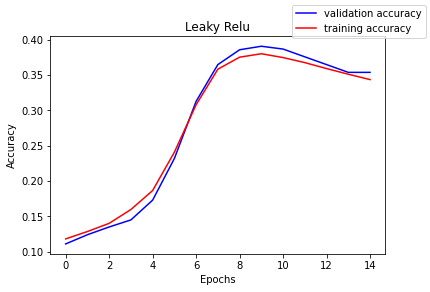

In [11]:
plt.plot(list(range(15)),validationLoss,  label = "validation accuracy", color = 'blue')
plt.plot(list(range(15)), trainLoss,  label = "training accuracy", color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Leaky Relu")
plt.figlegend()
plt.show()


In [ ]:
# tanh
myNet = MyNeuralNetwork(6, [784, 256, 128, 64, 32, 10], "tanh", 0.08, "normal", X_train.shape[0], 15)
validationLoss, trainLoss = myNet.fit(X_train, y_train, X_validation, y_validation)
y_pred = myNet.predict(X_test)



print("The accuracy for test set", myNet.score(X_test, y_test) )


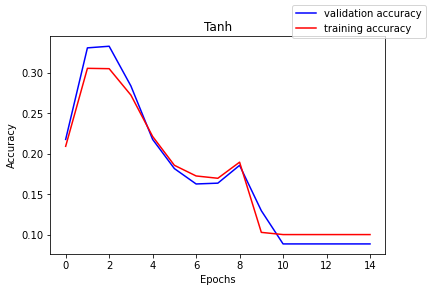

In [13]:
plt.plot(list(range(15)),validationLoss,  label = "validation accuracy", color = 'blue')
plt.plot(list(range(15)), trainLoss,  label = "training accuracy", color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Tanh")
plt.figlegend()
plt.show()


In [ ]:
# linear
myNet = MyNeuralNetwork(6, [784, 256, 128, 64, 32, 10], "linear", 0.08, "normal", X_train.shape[0], 9)
validationLoss, trainLoss = myNet.fit(X_train, y_train, X_validation, y_validation)
y_pred = myNet.predict(X_test)

print("The accuracy for test set", myNet.score(X_test, y_test) )




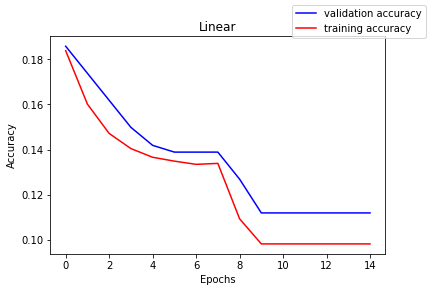

In [6]:
plt.plot(list(range(15)),validationLoss,  label = "validation accuracy", color = 'blue')
plt.plot(list(range(15)), trainLoss,  label = "training accuracy", color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Linear")
plt.figlegend()
plt.show()


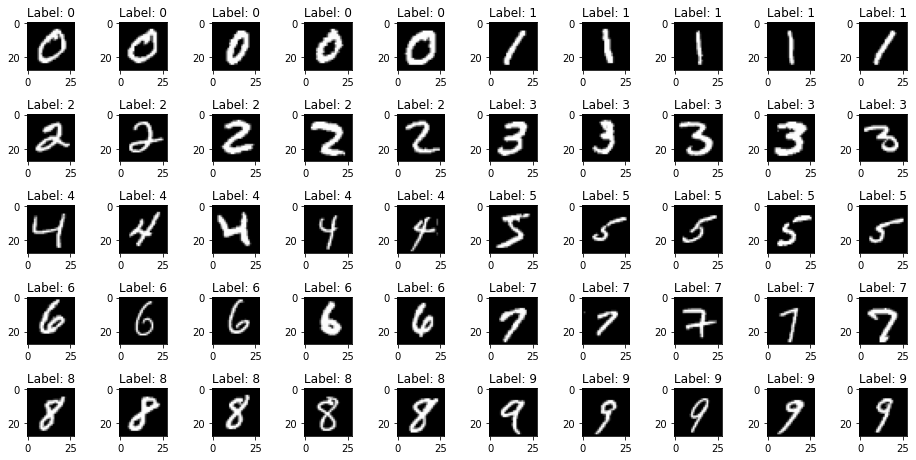

In [ ]:
digitDict = {}

for i in range(10):
    mask = (y == i)
    digitDict[i] = X[mask]

train_X = []
train_y = []

for i in range(10):
	for j in range(5):
		train_X.append(digitDict[i][j])
		train_y.append(i)

# plot images
num_row = 5
num_col = 10

fig, axes = plt.subplots(num_row, num_col, figsize=(1.3*num_col,1.3*num_row))
for i in range(50):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(train_X[i], cmap='gray')
    ax.set_title('Label: {}'.format(train_y[i]))
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier

# g, validation and test sets
seed(0)
((x_train, y_train), (x_test, y_test)) = tf.keras.datasets.mnist.load_data()
X = np.vstack((x_train, x_test))
y = np.hstack((y_train, y_test))

X = (X / 255) - 0.5
X = X.reshape((-1, 784))

In [ ]:
# X = X[:100]
indices = list(range(X.shape[0]))
training_instances = int(0.7 * X.shape[0])
validation_instances = int(0.1 * X.shape[0])
np.random.shuffle(indices)
train = indices[:training_instances]
validation = indices[training_instances:training_instances + validation_instances + 1]
test = indices[training_instances + validation_instances + 1:]

X_train, X_validation, X_test = X[train], X[validation], X[test]
y_train, y_validation, y_test = y[train], y[validation], y[test]
# y = to_categorical(y)


In [ ]:
clf = MLPClassifier(max_iter = 150, activation = "logistic", learning_rate_init = 0.08)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8534895349667834

In [ ]:
clf = MLPClassifier(max_iter = 150, activation = "identity", learning_rate_init = 0.08)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.867490535038217

In [ ]:
clf = MLPClassifier(max_iter = 150, activation = "relu", learning_rate_init = 0.08)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6281877276948353

In [ ]:
clf = MLPClassifier(max_iter = 150, activation = "tanh", learning_rate_init = 0.08)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5015358239874277

In [ ]:
# Bonus
# Using Relu
lrs = [0.001, 0.01, 0.1, 1]
testaccs = []
trainaccs = []
valaccs = []

for i in range(len(lrs)):
    myNet = MyNeuralNetwork(6, [784, 256, 128, 64, 32, 10], "relu", lrs[i], "normal", X_train.shape[0], 10)
    validationLoss, trainLoss = myNet.fit(X_train, y_train, X_validation, y_validation)
    # y_pred = myNet.predict(X_test)

    testaccs.append(myNet.score(X_test, y_test))
    valaccs.append(validationLoss)
    trainaccs.append(trainLoss)




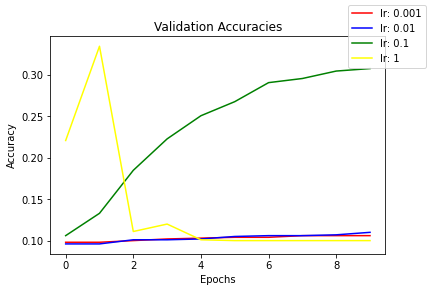

In [24]:
colors = ["red", "blue", "green", "yellow"]

for i in range(4):
    plt.plot(list(range(10)), valaccs[i],  label = "lr: " + str(lrs[i]), color = colors[i])

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracies")
plt.figlegend()
plt.show()


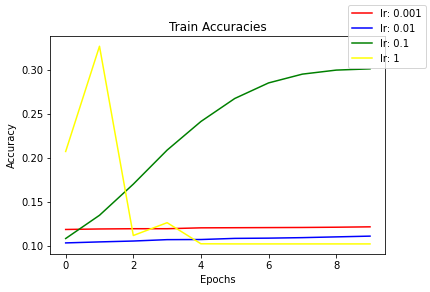

In [26]:
colors = ["red", "blue", "green", "yellow"]

for i in range(4):
    plt.plot(list(range(10)), trainaccs[i],  label = "lr: " + str(lrs[i]), color = colors[i])

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracies")
plt.figlegend()
plt.show()


No handles with labels found to put in legend.


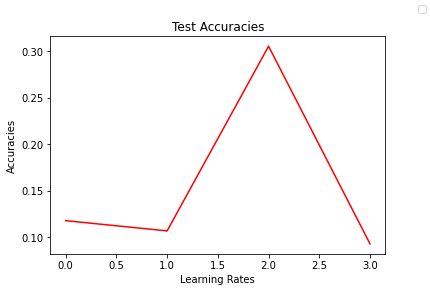

In [28]:
plt.plot(list(range(4)), testaccs, "red")

plt.xlabel("Learning Rates")
plt.ylabel("Accuracies")
plt.title("Test Accuracies")
plt.figlegend()
plt.show()
